(remote_sens_img_trans_orthorect)=
# Image transformations and orthorectification

A transformation in itself is a function that maps one set to another set. Geometric image transformations are widely used for registration and removal of geometric distortion. Common applications include the construction of mosaics, geographical mapping, robotic vision, satellite imagery, stereo imaging and video.

This notebook aims to demonstrate how the basic transformations work and some of its uses.

## Scaling

Scaling is the resizing of an image. When scaling a vector graphic image, the image can be scaled using geometric transformations with no loss of image quality. when scaling a raster image, a new image with a higher or lower number of pixels must be generated. When decreasing the pixel number (scaling down) this usually results in a visible quality loss. An example of scaling a raster image is shown below:

In [11]:
# import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# hit "o" to close window!
# read in image
img = cv2.imread('Data_Image_Transformations/Chessboard.jpg')

# resize image
height, width = img.shape[:2]
res = cv2.resize(img,(2*width, 2*height), interpolation = cv2.INTER_CUBIC)
# Preferable interpolation methods are cv2.INTER_AREA for shrinking and cv2.INTER_CUBIC (slow) & 
# cv2.INTER_LINEAR for zooming. By default, interpolation method used is cv2.INTER_LINEAR for all
# resizing purposes

# show change in full size
cv2.imshow('img',img)
cv2.imshow('res',res)
cv2.waitKey(0) # hit 0 to close window
cv2.destroyAllWindows()

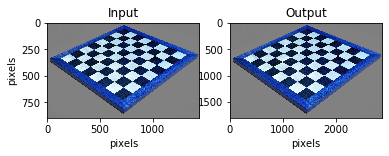

In [3]:
# show change in line
fig = plt.figure()
fig.add_subplot(121),plt.imshow(img),plt.title('Input')
plt.ylabel("pixels"), plt.xlabel("pixels")
fig.add_subplot(122),plt.imshow(res),plt.title('Output')
plt.xlabel("pixels")
plt.show()

## Translation
Translation is the shifting of an objects location. If you know the shift in (x,y) direction, let it be $(T_x, T_y)$, you can create the transformation matrix M as follows:
\\[ M = \begin{bmatrix}
1 & 0 & t_x\\
0 & 1 & t_y
\end{bmatrix}\\]

Note where the image axis point, commonly the origin lies at the top left.


In [12]:
# read in image
img = cv2.imread('Data_Image_Transformations/Chessboard.jpg',0)

# prepare variables
img = np.array(img)
rows,cols = img.shape

# translation function 
M = np.float32([[1,0,300],[0,1,100]])

# translation
dst = cv2.warpAffine(img,M,(cols,rows))

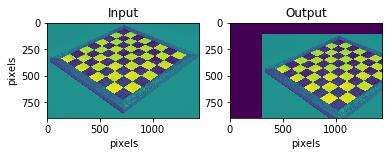

In [13]:
# show results
fig = plt.figure()
fig.add_subplot(121),plt.imshow(img),plt.title('Input')
plt.ylabel("pixels"), plt.xlabel("pixels")
fig.add_subplot(122),plt.imshow(dst),plt.title('Output')
plt.xlabel("pixels")
plt.show()

## Rotation

Rotation of an image for an angle $\theta$ is achieved by the transformation matrix of the form:
\\[ M = \begin{bmatrix}
 cos \theta & -sin\theta\\
 sin\theta & cos\theta
\end{bmatrix}\\]
OpenCv appends upon this to allow the rotation with adjustable centre of rotation. 

In [6]:
# read in image
img = cv2.imread('Data_Image_Transformations/Chessboard.jpg',0)

# set parameters
rows,cols = img.shape

# set rotation function
M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1) # 90 degrees, no scaling

# rotation
dst = cv2.warpAffine(img,M,(cols,rows))

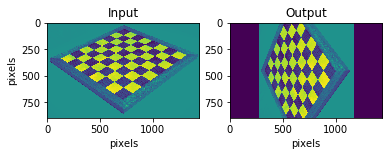

In [7]:
# show results
fig = plt.figure()
fig.add_subplot(121),plt.imshow(img),plt.title('Input')
plt.ylabel("pixels"), plt.xlabel("pixels")
fig.add_subplot(122),plt.imshow(dst),plt.title('Output')
plt.xlabel("pixels")
plt.show()

## Affine transformation

Affine transformation is a linear mapping method that preserves points, straight lines, and planes. all parallel lines in the original image will still be parallel in the output image. To find the transformation matrix, we need three points from the input image and their corresponding location in the output image.

Translation, scale, shear and rotation are al affine transformations. 

In [8]:
# script to find coordinates in input image, used for Affine and Perspective transformation

# double left click to set point and click 'a' to print coordinates
# click esc to close window

# read in image
img = cv2.imread('Data_Image_Transformations/Chessboard.jpg',0)

# draw selected points on image
n = 1
def draw_circle(event,x,y,flags,param):
    global mouseX,mouseY,n
    if event == cv2.EVENT_LBUTTONDBLCLK:
        cv2.circle(img,(x,y),10,(255,0,0),-1)
        cv2.putText(img,str(n),(x,y),cv2.FONT_HERSHEY_SIMPLEX,1,(255,180,180))
        mouseX,mouseY = x,y
        n = n + 1 

# allow for mouse input
cv2.namedWindow('image')
cv2.setMouseCallback('image',draw_circle)

# return mouse click x and y coordinates
while(1):
    cv2.imshow('image',img)
    k = cv2.waitKey(20) & 0xFF
    if k == 27:
        break
    elif k == ord('a'):
        print ('pos',n-1,' coord (x,y)=',mouseX,mouseY)

pos 1  coord (x,y)= 132 334
pos 2  coord (x,y)= 724 64
pos 3  coord (x,y)= 1315 302
pos 4  coord (x,y)= 720 729


In [14]:
# read in image
img = cv2.imread('Data_Image_Transformations/Chessboard.jpg',0)

# set parameters
rows,cols = img.shape
# original image coordinates
pts1 = np.float32([[131,334],[722,58],[1313,301]])
# where points should be placed 
pts2 = np.float32([[100,250],[800,150],[1000,500]])

# create matrix for transformation
M = cv2.getAffineTransform(pts1,pts2)

# transformation
dst = cv2.warpAffine(img,M,(cols,rows))

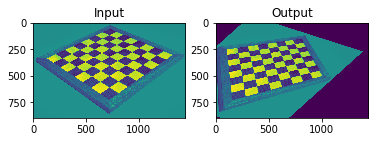

In [15]:
# show results
fig = plt.figure()
fig.add_subplot(121),plt.imshow(img),plt.title('Input')
fig.add_subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

## Perspective transformation

Perspective transformation or orthorectification removes effects from tilt in the image to create a planimetrically correct image. In other words, it generates an image as if it was captured from the vertical (on-Nadir). 

This can be done by multiple methods, some between many:
- if you can link image coordinates to real coordinates (or a made-up system) it is a simple transform function to find
- if you know where the picture was taken from and the camera orientation you can also find the required parameters for a perspective transformation

This can be taken one step further to account for relief (terrain), requires DEM model, the resultant orthorectified image has a constant scale wherein features are represented in their 'true' positions. This allows for the accurate direct measurement of distances, angles, and areas. Note that if considering water surfaces on small scale relief has only a minor effect.

In [16]:
# read in image
img = cv2.imread('Data_Image_Transformations/Chessboard.jpg',0)

# set parameters
rows,cols = img.shape
pts1 = np.float32([[131,334],[722,58],[1313,301],[716,725]])
pts2 = np.float32([[0,0],[300,0],[300,300],[0,300]])

# set function/matrix
M = cv2.getPerspectiveTransform(pts1,pts2)

# transformation
dst = cv2.warpPerspective(img,M,(300,300))

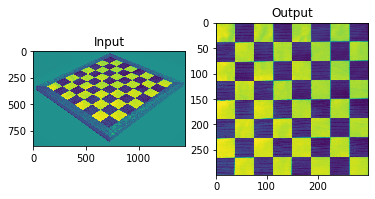

In [17]:
# show results
plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

## References

- Without CV2 the functions you design require to be slightly different, similar to the [Image Filtering notebook](https://primer-computational-mathematics.github.io/book/geosciences/Image_Filtering.html):<br /> Uk.mathworks.com. 2020. Affine Transformation. [online] Available at: <https://uk.mathworks.com/discovery/affine-transformation.html> [Accessed 13 July 2020].
- OpenCV functions:<br /> Opencv-python-tutroals.readthedocs.io. 2020. Geometric Transformations Of Images — Opencv-Python Tutorials 1 Documentation. [online] Available at: <https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html> [Accessed 13 July 2020].
- Notes on Image Transformations:<br />Cis.rit.edu. 2020. [online] Available at: <https://www.cis.rit.edu/class/simg782/lectures/lecture_02/lec782_05_02.pdf> [Accessed 13 July 2020].
- Detect mouse position on image:<br /> picture, O., Meshy, O. and Lad, A., 2020. Opencv: Detect Mouse Position Clicking Over A Picture. [online] Stack Overflow. Available at: <https://stackoverflow.com/questions/28327020/opencv-detect-mouse-position-clicking-over-a-pictur> [Accessed 13 July 2020].
- OpenCV full documentation:<br />Mordvintsev, A. and K, A., 2017. Opencv-Python Tutorials Documentation. 1st ed. [ebook] Available at: <https://buildmedia.readthedocs.org/media/pdf/opencv-python-tutroals/latest/opencv-python-tutroals.pdf> [Accessed 13 July 2020].
- Camera Calibration toolbox OpenCV:<br /> Opencv-python-tutroals.readthedocs.io. 2020. Camera Calibration — Opencv-Python Tutorials 1 Documentation. [online] Available at: <https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html> [Accessed 13 July 2020].
- Camera Calibration toolbox OpenCV scripts:<br />GitHub. 2020. Davidwangwood/Camera-Calibration-Python. [online] Available at: <https://github.com/DavidWangWood/Camera-Calibration-Python> [Accessed 13 July 2020].
- Orthorectification:<br />Trac.osgeo.org. 2020. Orthorectification – OSSIM. [online] Available at: <https://trac.osgeo.org/ossim/wiki/orthorectification> [Accessed 13 July 2020]. <br /> Hagolle, O., 2020. The Orthorectification : How It Works – Séries Temporelles. [online] Labo.obs-mip.fr. Available at: <https://labo.obs-mip.fr/multitemp/the-orthorectification-how-it-works/> [Accessed 13 July 2020].